This notebook aims to recreate the MaLSTM model for comparing sentences found  [here](https://github.com/likejazz/Siamese-LSTM). It utilizes the Quora question pairs dataset for training and saves out the model so that it can be used in comparing General Conference translations as a loss function.

Remember that there are some IP claims on the data and we can't actually use it for anything.

In [0]:
# !curl -o gc.zip https://students.cs.byu.edu/~kac1995/2000.zip

In [1]:
"""
  1. Mount Google Drive (no need to check if already mounted, it does that for you)
  2. 
"""
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import os
os.environ['KAGGLE_USERNAME'] = 'kennethchristensen'
os.environ['KAGGLE_KEY'] = '20890c9bf813dceb31ed6b65d2210769'

!kaggle competitions download -c quora-question-pairs

sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
!unzip train.csv.zip
!unzip test.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               
Archive:  test.csv.zip
  inflating: test.csv                


In [0]:
# root directory has a structure like "year/month/talk/[video|text]"
train_file = "/content/train.csv"
test_file = "/content/test.csv"
output_dir = "/content/gdrive/My Drive/CS474 Final Project/MaLSTM"

In [5]:
!pip3 install torch
!pip3 install tqdm
!pip install torchtext spacy
!python -m spacy download en
!pip3 install gensim

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import torchtext
import spacy
import pandas as pd
import gc
import itertools

import os
import math
from sklearn.model_selection import train_test_split

import re
from nltk.corpus import stopwords

import gensim.downloader as gensim_api
from IPython.core.ultratb import AutoFormattedTB
from torch.utils.data.sampler import SubsetRandomSampler

__ITB__ = AutoFormattedTB(mode = 'Verbose',color_scheme='LightBg', tb_offset = 1)

assert torch.cuda.is_available(), "You need to request a GPU from Runtime > Change Runtime"

In [5]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
model_glove_wikipedia = gensim_api.load("glove-wiki-gigaword-100")


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
train_df = pd.read_csv(train_file)
for q in ['question1', 'question2']:
    train_df[q + '_n'] = train_df[q]

# Make GloVE embeddings
embedding_dim = 100

tokenizer = spacy.load('en').tokenizer


In [0]:
train_df.dropna(inplace=True)

In [12]:
train_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,question1_n,question2_n
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?


In [0]:
def make_glove_embeddings(df, embedding_dim=100):
  vocabs = {}
  vocabs_cnt = 0

  stops = set(stopwords.words('english'))
  for index, row in df.iterrows():
    if index != 0 and index % 10000 == 0:
      print("{:,} sentences embedded.".format(index), flush=True)

    for question in ['question1', 'question2']:
      q2n = [] # q2n -> question numbers representation
      for word in tokenizer(row[question]):
        if word in stops:
          continue

        if word not in vocabs:
          vocabs_cnt += 1
          vocabs[word] = vocabs_cnt
          q2n.append(vocabs_cnt)
        else:
          q2n.append(vocabs[word])

      df.at[index, question + '_n'] = np.asarray(q2n)
  
  embeddings = 1 * np.random.randn(len(vocabs) + 1, embedding_dim)  # This will be the embedding matrix
  embeddings[0] = 0 # Whatever padding?

  for word, index in vocabs.items():
    if word in model_glove_wikipedia.vocab:
      embeddings[index] = model_glove_wikipedia[word]
  
  return df, torch.tensor(embeddings)
        

In [14]:
train_df, embeddings = make_glove_embeddings(train_df)

10,000 sentences embedded.
20,000 sentences embedded.
30,000 sentences embedded.
40,000 sentences embedded.
50,000 sentences embedded.
60,000 sentences embedded.
70,000 sentences embedded.
80,000 sentences embedded.
90,000 sentences embedded.
100,000 sentences embedded.
110,000 sentences embedded.
120,000 sentences embedded.
130,000 sentences embedded.
140,000 sentences embedded.
150,000 sentences embedded.
160,000 sentences embedded.
170,000 sentences embedded.
180,000 sentences embedded.
190,000 sentences embedded.
200,000 sentences embedded.
210,000 sentences embedded.
220,000 sentences embedded.
230,000 sentences embedded.
240,000 sentences embedded.
250,000 sentences embedded.
260,000 sentences embedded.
270,000 sentences embedded.
280,000 sentences embedded.
290,000 sentences embedded.
300,000 sentences embedded.
310,000 sentences embedded.
320,000 sentences embedded.
330,000 sentences embedded.
340,000 sentences embedded.
350,000 sentences embedded.
360,000 sentences embedded.
3

In [0]:
def split_and_zero_padding(df):
    # Split to dicts
    # print("Type of df['question1_n'] {}".format(type(df['question1_n'])))
    left = [ torch.zeros((300)) ] + [torch.tensor(i) for i in df['question1_n'].values]
    right = [ torch.zeros((300)) ] + [torch.tensor(i) for i in df['question2_n'].values]

    left = torch.nn.utils.rnn.pad_sequence(left)
    right = torch.nn.utils.rnn.pad_sequence(right)
    
    return { "left": left[:,1:], "right": right[:,1:] }

In [0]:
# Split to train validation
validation_size = int(len(train_df) * 0.1)
training_size = len(train_df) - validation_size

X = train_df[['question1_n', 'question2_n']]
Y = train_df['is_duplicate']

X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size)


In [0]:
X_train = split_and_zero_padding(X_train)
X_validation = split_and_zero_padding(X_validation)

# Convert labels to their numpy representations
Y_train = Y_train.values
Y_validation = Y_validation.values

In [0]:
class SentenceDataset(Dataset):
  def __init__(self, sentences, labels):
    self.sentences = sentences
    self.labels = labels

  def __len__(self):
    return self.sentences['left'].shape[1]
  
  def __getitem__(self, i):
    return self.sentences['left'][:,i], self.sentences['right'][:,i], self.labels[i]


In [23]:
print("{} {}".format(X_train['left'].shape, X_train['right'].shape))
print("{} {}".format(len(X_train['left']), len(Y_train)))
assert X_train['left'].shape == X_train['right'].shape
assert X_train['left'].shape[1] == len(Y_train)

torch.Size([300, 363859]) torch.Size([300, 363859])
300 363859


In [24]:
embeddings[[1,3,3]].shape

torch.Size([3, 100])

In [0]:
class EmbeddingLookupModule(nn.Module):
  def forward(self, l):
    l = l.int().numpy()
    # print(type(l))
    # print("l size: {}".format(l.shape))
    res = torch.tensor(embeddings[l]).float().transpose(0,1)
    # print("Looked up size: {}".format(res.size()))
    return res.cuda()

In [0]:
model = nn.Sequential(
    EmbeddingLookupModule(),
    nn.LSTM(input_size=100, hidden_size=200)
)

In [0]:
def compute_manhattan(h1, h2):
  return torch.exp(-torch.sum(torch.abs(h1 - h2), axis=2))

In [0]:
num_epochs = 50
batch_size = 1024



In [40]:
Y_train
X_train['left'].size()

torch.Size([300, 363859])

In [0]:
train_dataset = SentenceDataset(X_train, Y_train)
valid_dataset = SentenceDataset(X_validation, Y_validation)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)

In [0]:
objective = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [43]:
train_dataset[0][0].size()

torch.Size([300])

In [44]:
len(train_dataset)

363859

In [0]:
model = model.cuda()

In [52]:
lowest_loss = float('inf')

train_losses = []
validation_losses = []
train_acc = []
valid_acc = []

for epoch in range(num_epochs):
  tot = 0
  cnt = 0
  acc_tot = 0
  acc_cnt = 0

  for q1, q2, y in train_loader:
    y = y.cuda(async=False)
    optimizer.zero_grad()

    _, (h1, _) = model(q1)
    _, (h2, _) = model(q2)
    
    dist = compute_manhattan(h1, h2).squeeze(0)

    # print(h1.size())
    # print(dist.size())
    # print(y.size())
    # print(y)

    loss = objective(dist, y.float())

    loss.backward()
    optimizer.step()
    print("Epoch: {}, Loss: {}".format(epoch, loss.item()))

    if loss.item() < lowest_loss:
      torch.save(model.state_dict(), os.path.join(output_dir, "e{}_l{}.mod".format(epoch, loss.item())))
      lowest_loss = loss.item()
    tot += loss.item()
    cnt += 1

    accuracy = 1- (torch.nonzero(dist - y).size(0) / len(y))
    acc_tot += accuracy
    acc_cnt += 1
  train_acc.append((epoch, acc_tot / acc_cnt))
  train_losses.append((epoch, tot / cnt))

  if epoch != 0 and epoch % 10 == 0:
    tot = 0
    cnt = 0
    acc_tot = 0
    acc_cnt = 0
    with torch.no_grad():
      for q1, q2, y in valid_loader:
        y = y.cuda(async=False)
        _, (h1, _) = model(q1)
        _, (h2, _) = model(q2)
        
        dist = compute_manhattan(h1, h2).squeeze(0)
        loss = objective(dist, y.float())

        print("Epoch: {}, Valid Loss: {}".format(epoch, loss.item()))
        tot += loss.item()
        cnt += 1

        accuracy = 1 - (torch.nonzero(dist - y).size(0) / len(y))
        acc_tot += accuracy
        acc_cnt += 1
      valid_acc.append((epoch, acc_tot / acc_cnt))
      validation_losses.append((epoch, tot / cnt))



  



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Epoch: 0, Loss: 0.6123043298721313
Epoch: 0, Loss: 0.6328122019767761
Epoch: 0, Loss: 0.6503902673721313
Epoch: 0, Loss: 0.6308589577674866
Epoch: 0, Loss: 0.6269527077674866
Epoch: 0, Loss: 0.6347652077674866
Epoch: 0, Loss: 0.6367183923721313
Epoch: 0, Loss: 0.6572262048721313
Epoch: 0, Loss: 0.6484371423721313
Epoch: 0, Loss: 0.6210933327674866
Epoch: 0, Loss: 0.6328121423721313
Epoch: 0, Loss: 0.6513667702674866
Epoch: 0, Loss: 0.6396480202674866
Epoch: 0, Loss: 0.6181636452674866
Epoch: 0, Loss: 0.6259761452674866
Epoch: 0, Loss: 0.6328121423721313
Epoch: 0, Loss: 0.6269527673721313
Epoch: 0, Loss: 0.6230464577674866
Epoch: 0, Loss: 0.6328120827674866
Epoch: 0, Loss: 0.6425777077674866
Epoch: 0, Loss: 0.6445308327674866
Epoch: 0, Loss: 0.6533198952674866
Epoch: 0, Loss: 0.6562496423721313
Epoch: 0, Loss: 0.6201167702674866
Epoch: 0, Loss: 0.6435542702674866
Epoch: 0, Loss: 0.6357417702674866
Epoch: 0, Loss: 0.6152339577674866
Epoch: 0, Loss: 0.6259761452674866
Epoch: 0, Loss: 0.61

NameError: ignored

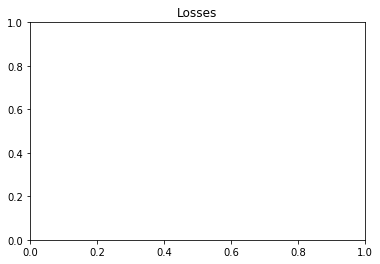

In [1]:
import matplotlib.pyplot as plt

plt.title("Losses")
plt.plot(*zip(*train_losses), label="Training")
plt.plot(*zip(*validation_losses), label="Validation")
plt.legend(loc="upper right")
plt.show()

plt.plot(train_acc)
plt.title("Training accuracies")
plt.show()

plt.plot(valid_acc)
plt.title("Validation accuracies")
plt.show()

In [2]:
model

NameError: ignored

In [0]:
# test_module = EmbeddingLookupModule()
# test_lstm = nn.LSTM()
inp = X_train['left']
# print(test_module(inp).size())

print(inp.size())
model(inp)

In [0]:
def translate_emb(embeddings):
  results = []
  for e in embeddings.numpy():
    top_choices = model_glove_wikipedia.similar_by_vector(e)
    words, weights = zip(*top_choices)
    weights = np.asarray(weights)
    weights /= np.sum(weights)
    word = np.random.choice(words, p=weights)
    results.append(word)
  return results

In [0]:
model.cuda()
f.cuda()

In [0]:
f[0:100].size()

torch.Size([100, 3, 224, 224])

In [0]:
def scope(s):
  try:
    #your code for calling dataset and dataloader
    gc.collect()
    torch.cuda.empty_cache()

    model(f[0:s].cuda())
  except:
    __ITB__()
    raise


In [0]:
scope(100)

torch.Size([100, 3, 224, 224])
torch.Size([100, 100])


In [0]:
model = model.cpu()

In [0]:
f.cpu()

In [0]:
import torch.cuda as cutorch

for i in range(cutorch.device_count()):
     if cutorch.getMemoryUsage(i) > MEM: 
         opts.gpuID = i
         break

AttributeError: ignored

In [0]:
def clean():
  gc.collect()
  torch.cuda.empty_cache()

In [0]:
!pip install gputil
import GPUtil as GPU

def check_gpu():
  GPUs = GPU.getGPUs()
  gpu = GPUs[0]
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

check_gpu()

GPU RAM Free: 6877MB | Used: 9403MB | Util  58% | Total 16280MB
